# In this notebook
I determine whether the ACS agreggated block group data is sufficient for our needs.

The data comes from
https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/tiger-line-demo-record-layouts.html



In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from matplotlib import pyplot as plt

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_10544/3790910204.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# List the layers contained in this database
fiona.listlayers('../data/raw/census/ACS_2020_5YR_BG_37_NORTH_CAROLINA.gdb/')

['X09_CHILDREN_HOUSEHOLD_RELATIONSHIP',
 'X11_HOUSEHOLD_FAMILY_SUBFAMILIES',
 'X14_SCHOOL_ENROLLMENT',
 'X28_COMPUTER_AND_INTERNET_USE',
 'X29_VOTING_AGE_POPULATION',
 'X99_IMPUTATION',
 'X01_AGE_AND_SEX',
 'X02_RACE',
 'X03_HISPANIC_OR_LATINO_ORIGIN',
 'X07_MIGRATION',
 'X08_COMMUTING',
 'X12_MARITAL_STATUS_AND_HISTORY',
 'X15_EDUCATIONAL_ATTAINMENT',
 'X16_LANGUAGE_SPOKEN_AT_HOME',
 'X17_POVERTY',
 'X19_INCOME',
 'X20_EARNINGS',
 'X21_VETERAN_STATUS',
 'X22_FOOD_STAMPS',
 'X23_EMPLOYMENT_STATUS',
 'X24_INDUSTRY_OCCUPATION',
 'X25_HOUSING_CHARACTERISTICS',
 'X27_HEALTH_INSURANCE',
 'BG_METADATA_2020',
 'ACS_2020_5YR_BG_37_NORTH_CAROLINA']

In [9]:
# Open up the block data
bg = gpd.read_file('../data/raw/census/ACS_2020_5YR_BG_37_NORTH_CAROLINA.gdb/', driver='FileGDB', layer='ACS_2020_5YR_BG_37_NORTH_CAROLINA')#, rows=3)
durham = bg[bg['COUNTYFP'] == '063']

In [6]:
inc_geoids = []
income = []
income_error = []

with fiona.open('../data/raw/census/ACS_2020_5YR_BG_37_NORTH_CAROLINA.gdb/', driver='FileGDB', layer='X19_INCOME') as src:
    meta = src.meta

    for feature in src:
        inc_geoids.append(feature['properties']['GEOID'])
        income.append(feature['properties']['B19013e1'])
        income_error.append(feature['properties']['B19013m1'])

In [7]:
pop_geoids = []
population = []
population_error = []

with fiona.open('../data/raw/census/ACS_2020_5YR_BG_37_NORTH_CAROLINA.gdb/', driver='FileGDB', layer='X01_AGE_AND_SEX') as src:
    meta = src.meta

    for feature in src:
        pop_geoids.append(feature['properties']['GEOID'])
        population.append(feature['properties']['B01003e1'])
        population_error.append(feature['properties']['B01003m1'])


In [8]:
income_df = pd.DataFrame({'geoid': inc_geoids, 'income': income, 'income_error': income_error})
pop_df = pd.DataFrame({'geoid': pop_geoids, 'population': population, 'population_error': population_error})

In [10]:
# Add the population and income dataframes
durham = durham.merge(pop_df, left_on='GEOID_Data', right_on='geoid')
durham = durham.merge(income_df, left_on='GEOID_Data', right_on='geoid')

<Axes: >

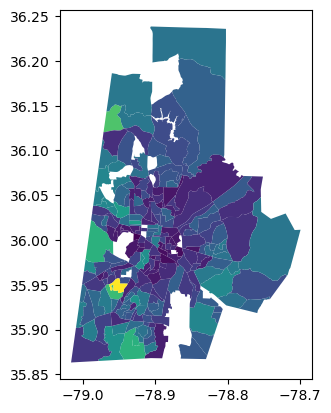

In [12]:
# Print out columns
durham.plot(column='income')

<Axes: >

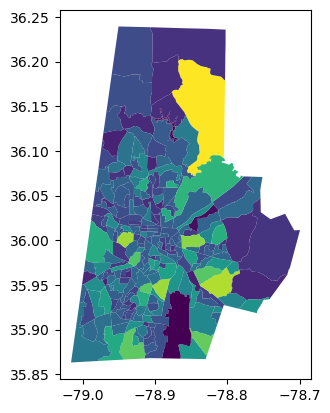

In [13]:
durham.plot('population')

<Axes: >

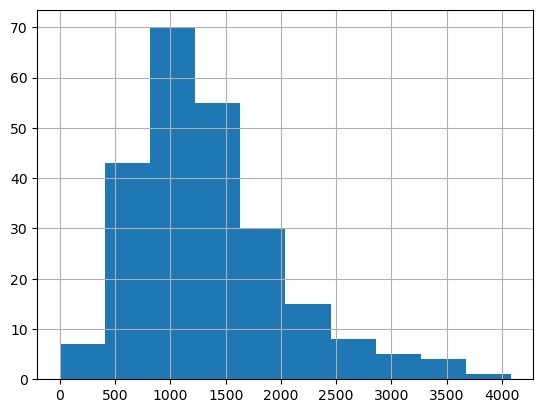

In [14]:
durham.population.hist()

In [17]:
durham.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Shape_Length,Shape_Area,GEOID_Data,geometry,geoid_x,population,population_error,geoid_y,income,income_error
0,37,063,001801,3,370630018013,Block Group 3,G5030,S,6464902.0,1821762.0,...,0.163264,0.000829,15000US370630018013,"MULTIPOLYGON (((-78.82079 36.04266, -78.81975 ...",15000US370630018013,900.0,474.0,15000US370630018013,78324.0,1700.0
1,37,063,001708,4,370630017084,Block Group 4,G5030,S,3576476.0,162732.0,...,0.128387,0.000374,15000US370630017084,"MULTIPOLYGON (((-78.89638 36.05947, -78.89558 ...",15000US370630017084,1175.0,405.0,15000US370630017084,75729.0,57770.0
2,37,063,001601,6,370630016016,Block Group 6,G5030,S,853369.0,71621.0,...,0.200460,0.000093,15000US370630016016,"MULTIPOLYGON (((-78.90575 36.13901, -78.90548 ...",15000US370630016016,0.0,13.0,15000US370630016016,NaN,NaN
3,37,063,002037,2,370630020372,Block Group 2,G5030,S,5587220.0,20203.0,...,0.112114,0.000560,15000US370630020372,"MULTIPOLYGON (((-78.86798 35.88224, -78.86712 ...",15000US370630020372,2168.0,405.0,15000US370630020372,78250.0,16836.0
4,37,063,002038,2,370630020382,Block Group 2,G5030,S,10845441.0,55347.0,...,0.146196,0.001088,15000US370630020382,"MULTIPOLYGON (((-78.85279 35.90356, -78.85278 ...",15000US370630020382,1911.0,542.0,15000US370630020382,120875.0,62194.0


In [28]:
durham.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape_Length', 'Shape_Area', 'GEOID_Data', 'geometry', 'geoid_x',
       'population', 'population_error', 'geoid_y', 'income', 'income_error'],
      dtype='object')

In [34]:
# Only keep the columns we care about
columns = ['GEOID', 'ALAND', 'AWATER', 'geometry', 'population', 'population_error', 'income', 'income_error']
durham = durham[columns]

# rename columns
durham.columns = ['geoid', 'landarea', 'waterarea', 'geometry', 'pop', 'pop_error', 'income', 'income_err']


In [35]:
# Save the data as a shape file
durham.to_file('../data/preprocessed/census_blocks/durham_block_group.shp')